## Searchlight Analysis

Nilearn is a python module for statistical and machine learning analysis on brain data. In this notebook, we will conduct searchlight analysis with this module

In [1]:
# install the package
!pip install nilearn

In [2]:
# import package
import glob
import numpy as np
from nilearn.image import new_img_like, load_img, get_data

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


## Import Dataset

In [5]:
# austim group
path_autism = 'abide_for_yilin/fmri/download/autism'
images_autism = glob.glob(path_autism + '/*.nii.gz')
# control group
path_control = 'abide_for_yilin/fmri/download/control'
images_control = glob.glob(path_control + '/*.nii.gz')

In [6]:
images = images_autism + images_control
len(images)

1099

In [7]:
# transform all images into one large image set result_img
from nilearn.image import smooth_img
result_img = smooth_img(images,None) 

In [8]:
len(result_img)

1099

In [9]:
# austim group
len(images_autism)

529

In [10]:
# control group
len(images_control)

570

## Searchlight : finding voxels containing information

The searchlight code simply searches for every voxel in the mask that is equal to 1 and then centers a searchlight around this. This means that for every value of 1 in your mask, the searchlight function will apply your kernel function. Hence when writing the kernel you need to keep in mind that the input data that the function receives is not the size of the original data but is instead the size of the **searchlight radius**. In other words, you might give the searchlight function a brain and mask volume that is 64x64x64 but each kernel operation only runs on a data and mask volume that is 3x3x3 (or whatever your searchlight radius is). As per the logic of searchlights, the center of each mask in the searchlight will be equal to 1

If we do not have a spatial mask of the target regions, a brain mask can be computed from the data

return: the whole-brain mask (3D image)

In [13]:
from nilearn.masking import compute_brain_mask
mask_img = compute_brain_mask(result_img)

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [14]:
mask_img

In [15]:
mask_arr = get_data(mask_img)
mask_arr.shape

(61, 73, 61)

/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



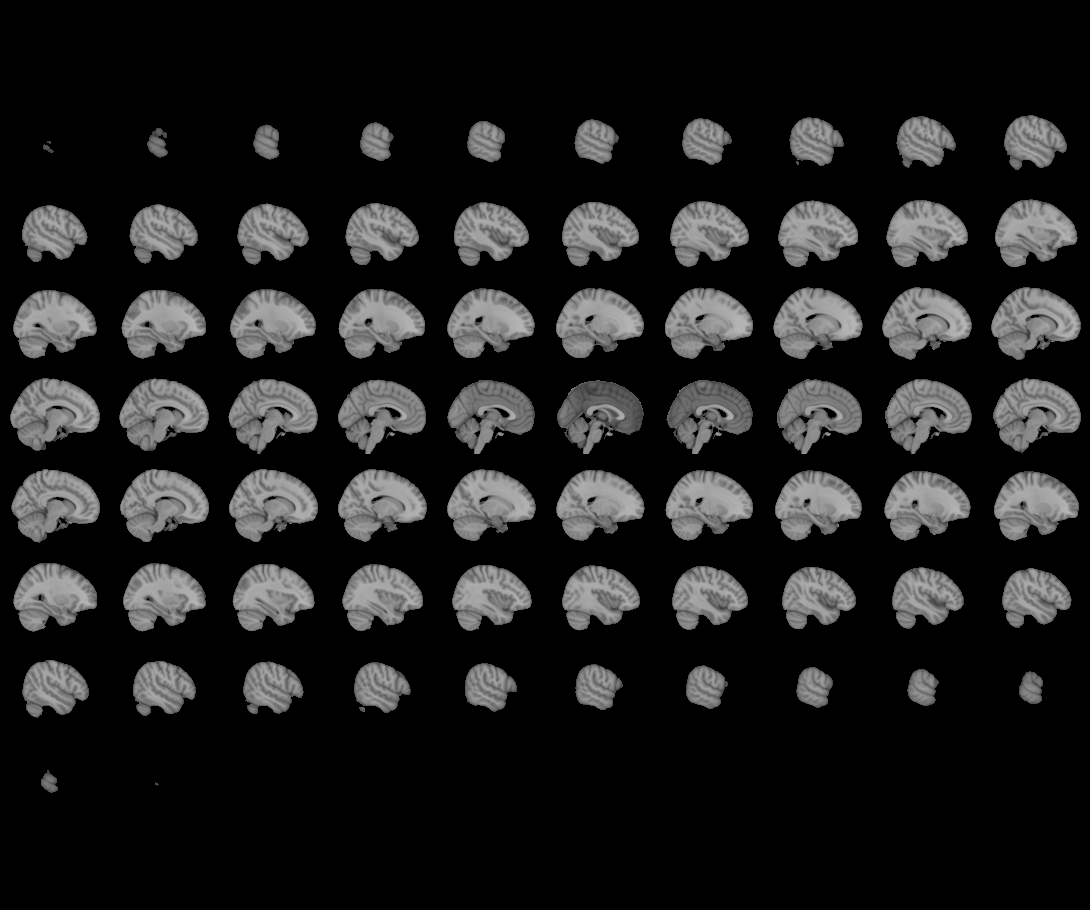
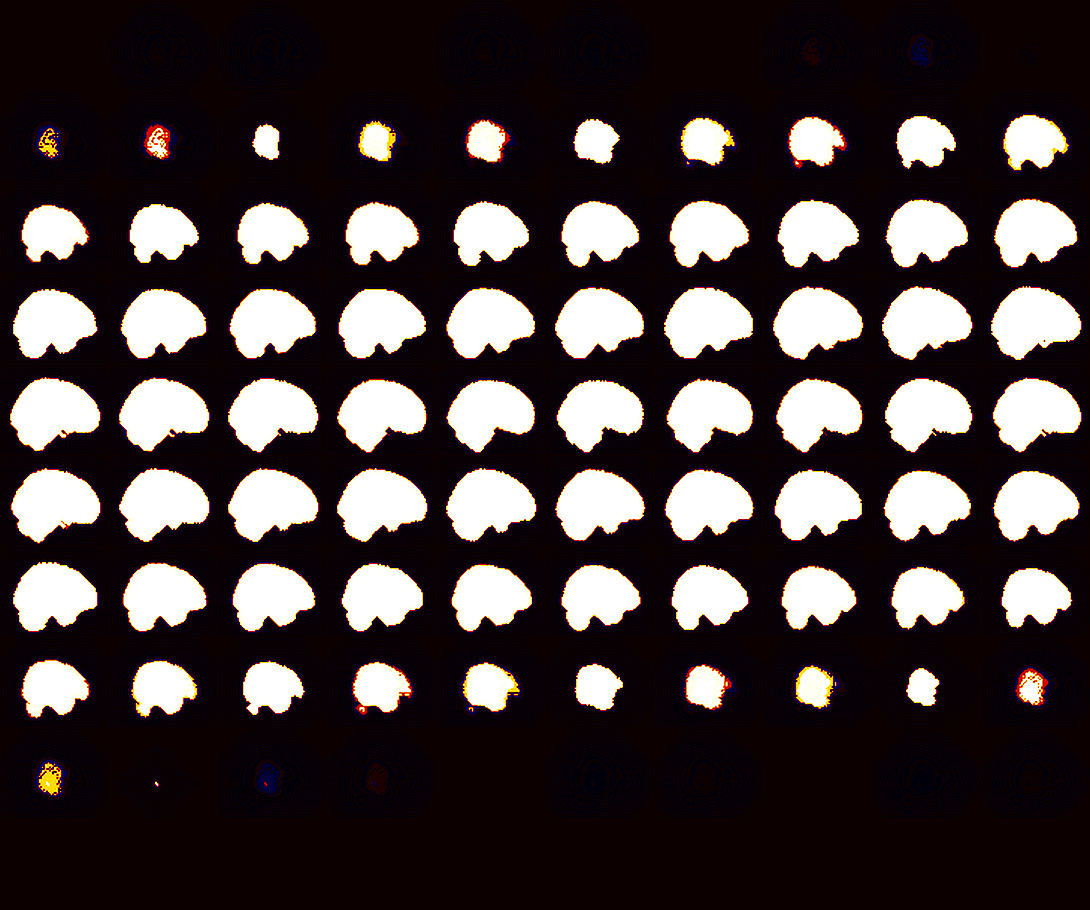

In [16]:
from nilearn import plotting
plotting.view_img(mask_img, threshold=None)

In [17]:
# create label for training
y = np.array([1]*529+[0]*570, dtype=np.int64)

**nilearn.decoding.SearchLight**(mask_img, process_mask_img=None, radius=2.0, estimator='svc', n_jobs=1, scoring=None, cv=None, verbose=0)

mask_img: boolean image giving location of voxels containing usable signals

process_mask_img: boolean image giving voxels on which searchlight should be computed

radius: radius of the searchlight ball, in millimeters. Defaults to 2



**method: 5-fold cross validation, radius 9, svc with rbf kernel**

In [19]:
from sklearn import svm
rbf_svc = svm.SVC(kernel='rbf', C=8)

In [20]:
n_jobs = 1
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)

import nilearn.decoding
# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = nilearn.decoding.SearchLight(
    mask_img,
    radius=9, n_jobs=n_jobs,
    verbose=1,cv=cv, estimator=rbf_svc)
searchlight.fit(result_img, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min finished


SearchLight(cv=KFold(n_splits=5, random_state=None, shuffle=False),
            estimator=SVC(C=8, break_ties=False, cache_size=200,
                          class_weight=None, coef0=0.0,
                          decision_function_shape='ovr', degree=3,
                          gamma='scale', kernel='rbf', max_iter=-1,
                          probability=False, random_state=None, shrinking=True,
                          tol=0.001, verbose=False),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f297324b350>,
            n_jobs=1, process_mask_img=None, radius=9, scoring=None, verbose=1)

**Result**\
the output of the searchlight analysis is a 3D volume with the outputs of your kernel for each voxel it was centered on

The **searchlight.scores_** are of the same shape as process_mask_img :

Outside this mask, scores are 0.
For a voxel i inside this mask, its score, searchlight.scores_[i], is the average classification score for all voxels in the searchlight centered on i

In [21]:
score = searchlight.scores_

In [22]:
score_array = np.array(score).reshape(-1)

In [23]:
score

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [24]:
from scipy.stats import wilcoxon
rank, pVal = wilcoxon(score_array - 0.5)
print(pVal)

0.0


In [25]:
score[score>0.7]

array([0.75, 0.8 , 0.85, ..., 0.8 , 0.75, 0.8 ])

In [26]:
np.nonzero(score > 0.7)

(array([ 7,  7,  7, ..., 53, 53, 53]),
 array([26, 27, 27, ..., 34, 35, 36]),
 array([28, 29, 30, ..., 16, 17, 17]))

**Visualization**

**goal**: visualize what functional features are used to distinguish between the groups and where in the brain function diverge

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


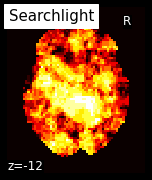

In [27]:
from nilearn import image
mean_fmri = image.mean_img(result_img)
#mean_fmri = 'download/autism/1.nii.gz'
from nilearn.plotting import plot_stat_map, plot_img, show
searchlight_img = new_img_like(mean_fmri, searchlight.scores_)

# plot_stat_map
plot_img(searchlight_img, bg_img=mean_fmri,
         title="Searchlight",cmap='hot',black_bg=True,display_mode="z", cut_coords=[-12],vmin=.42)

show()

3D visualization for different threshold of accuracy


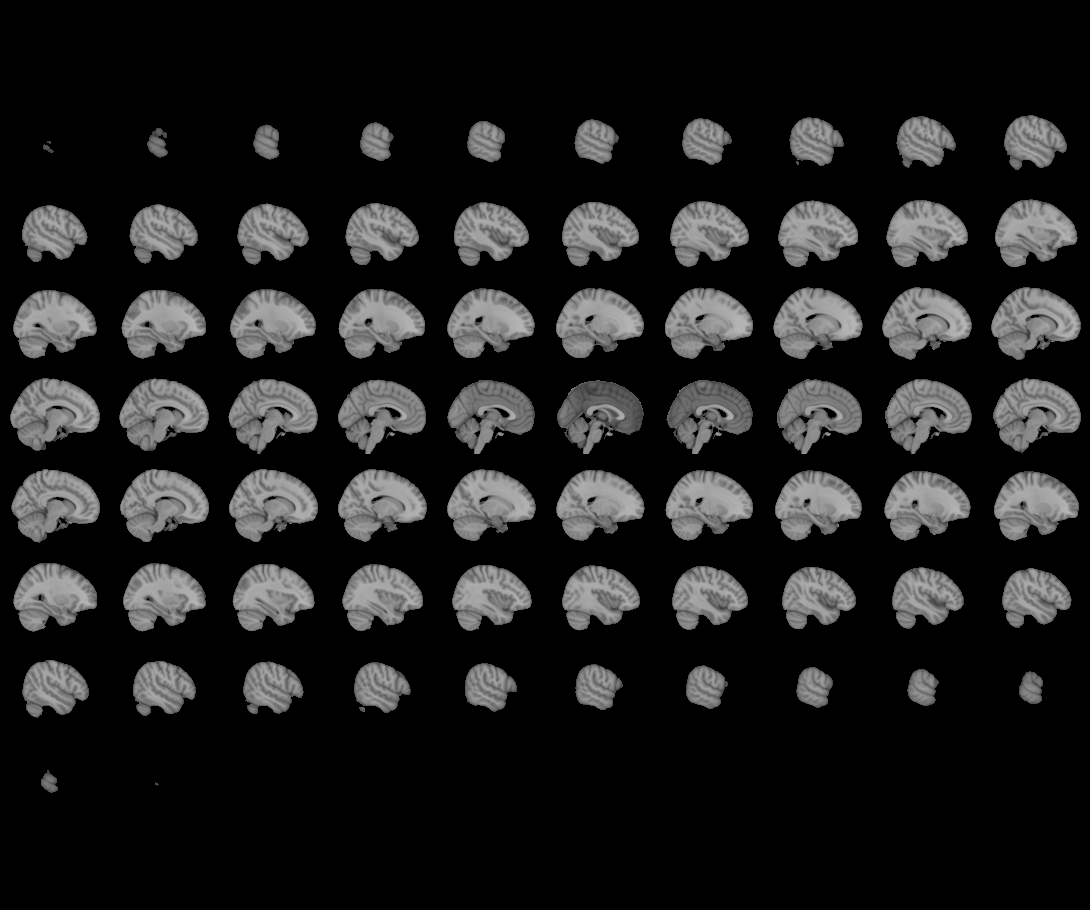
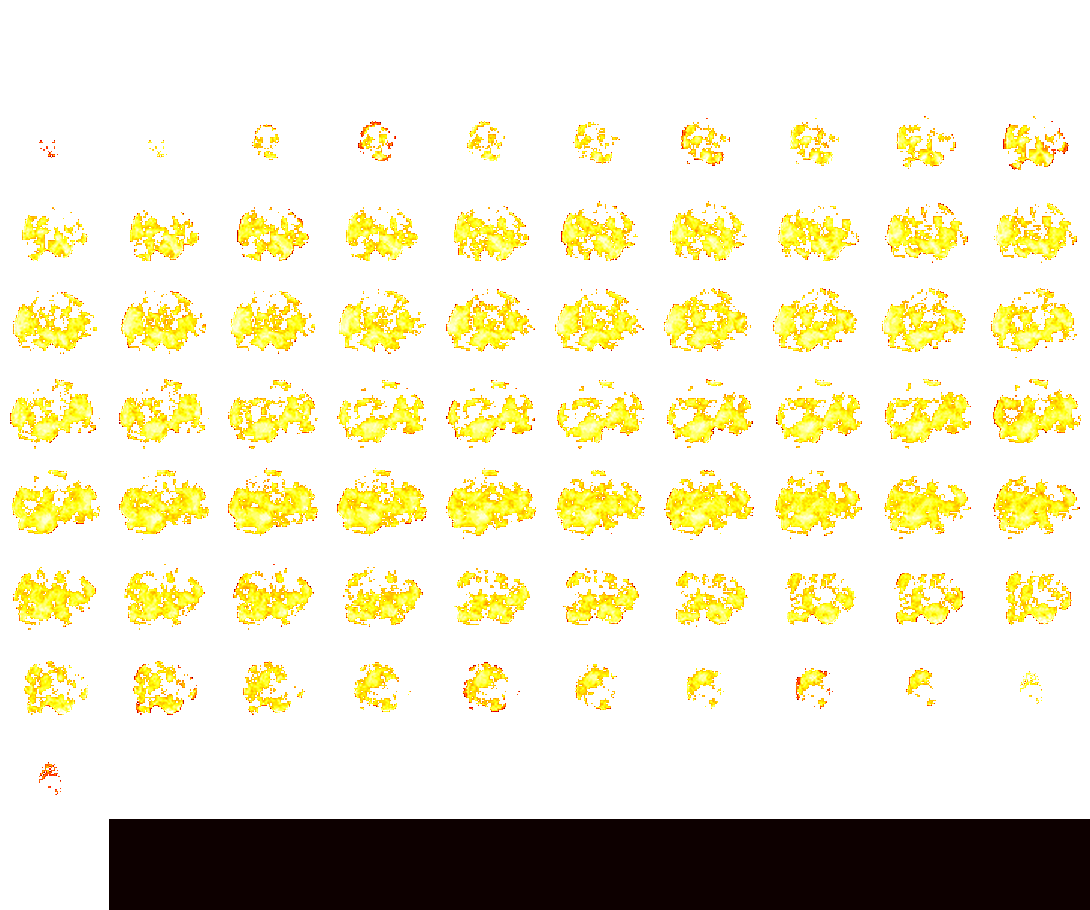

In [28]:
plotting.view_img(searchlight_img, threshold=0.6)


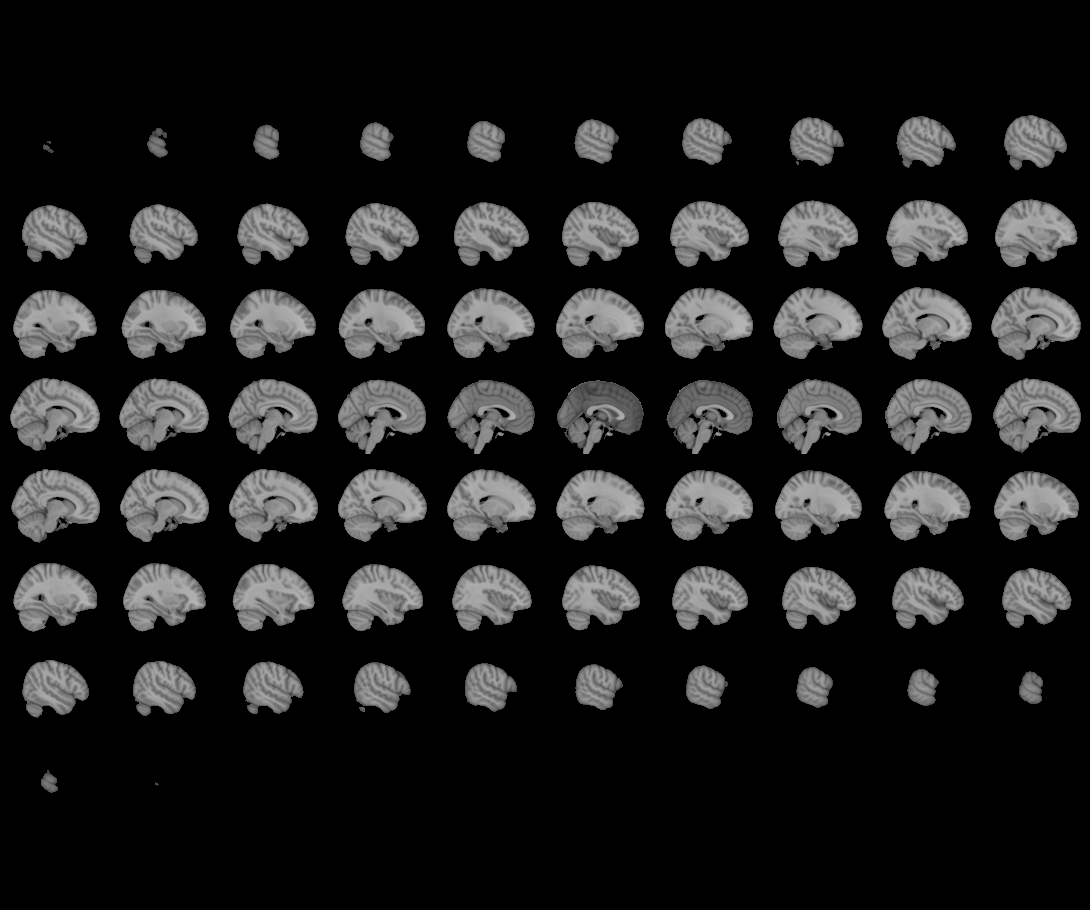
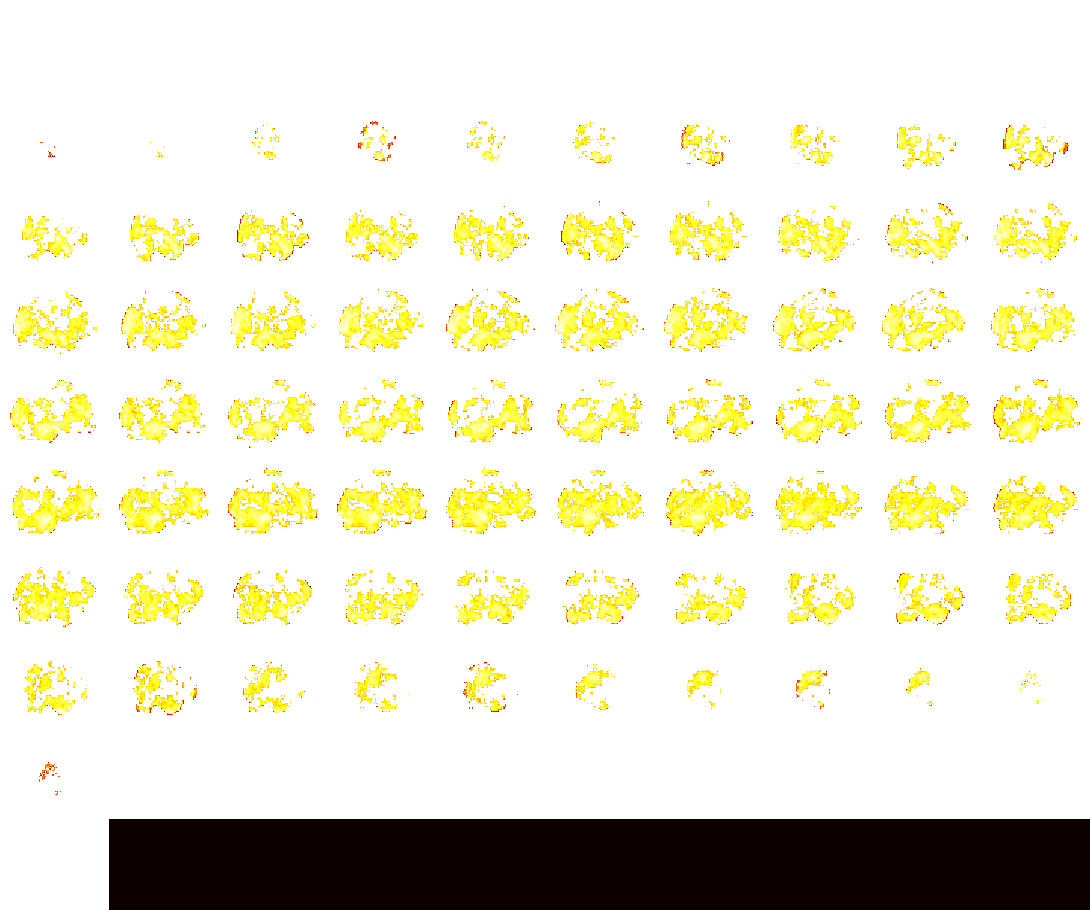

In [29]:
plotting.view_img(searchlight_img, threshold=0.65)


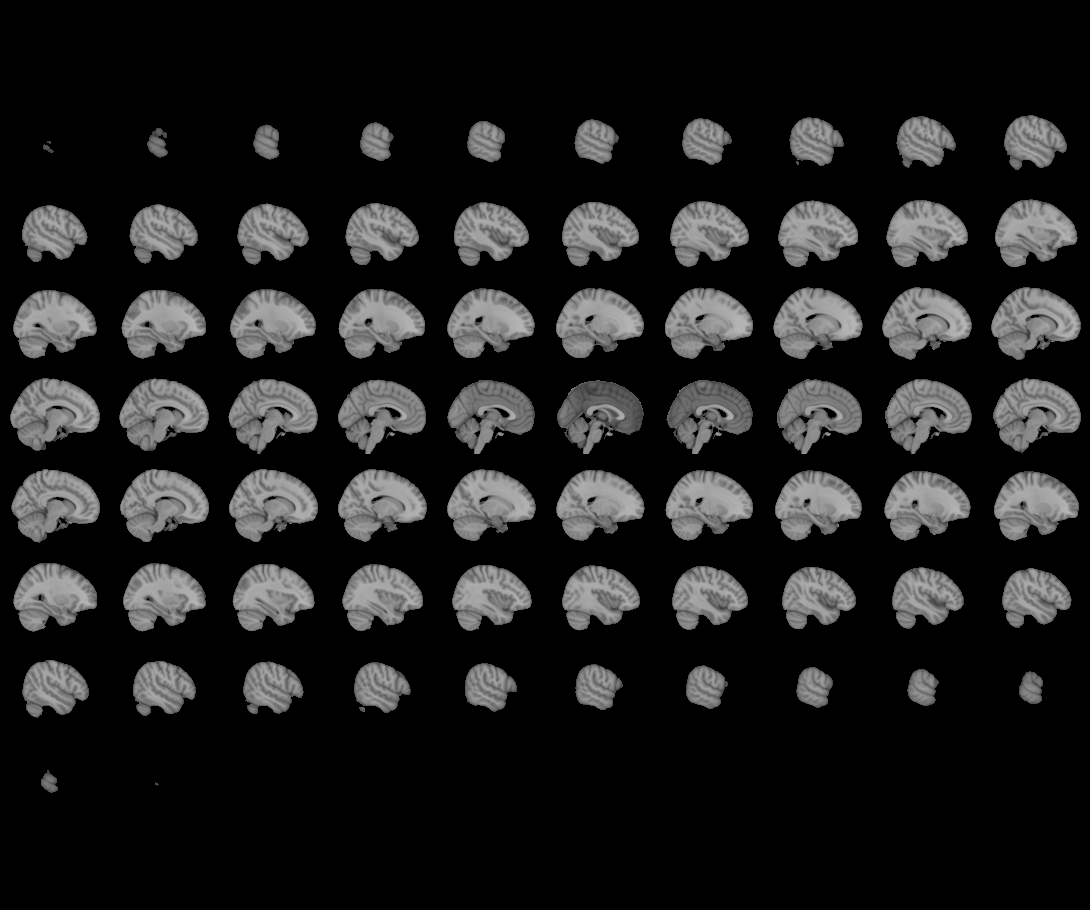
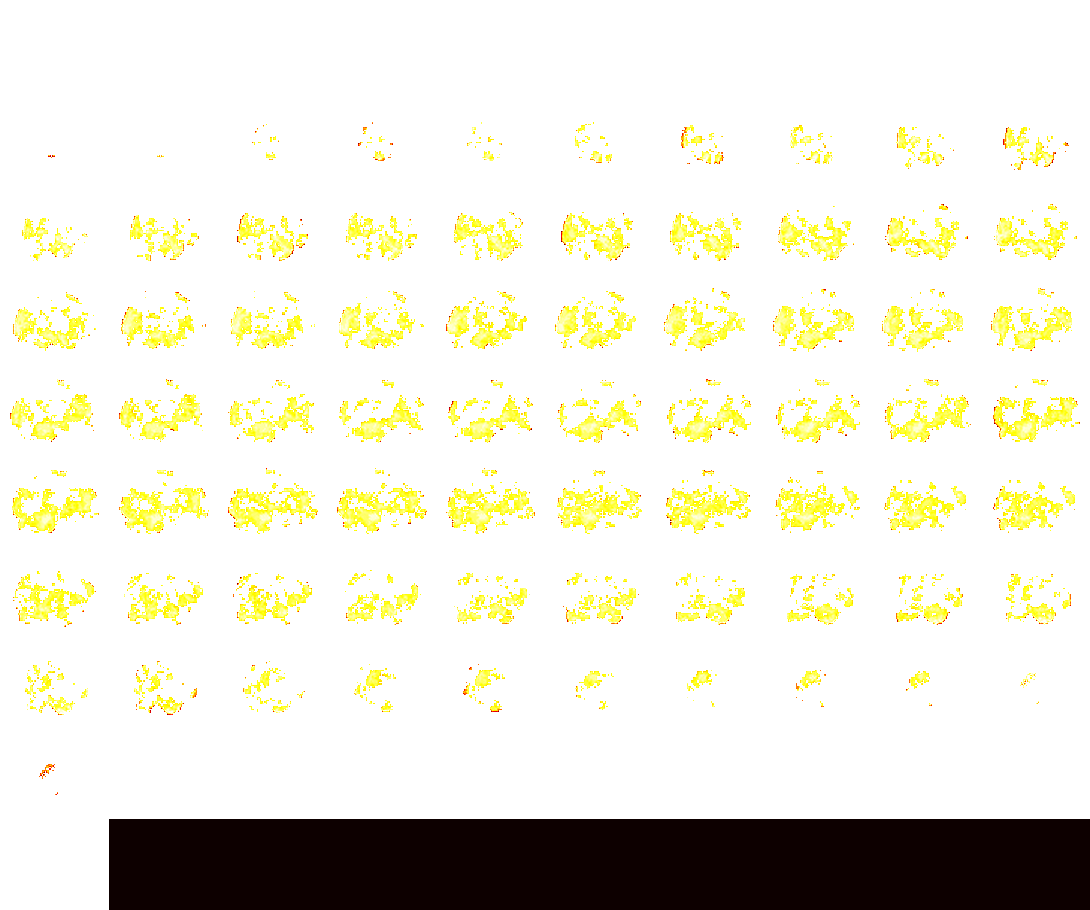

In [30]:
plotting.view_img(searchlight_img, threshold=0.7)


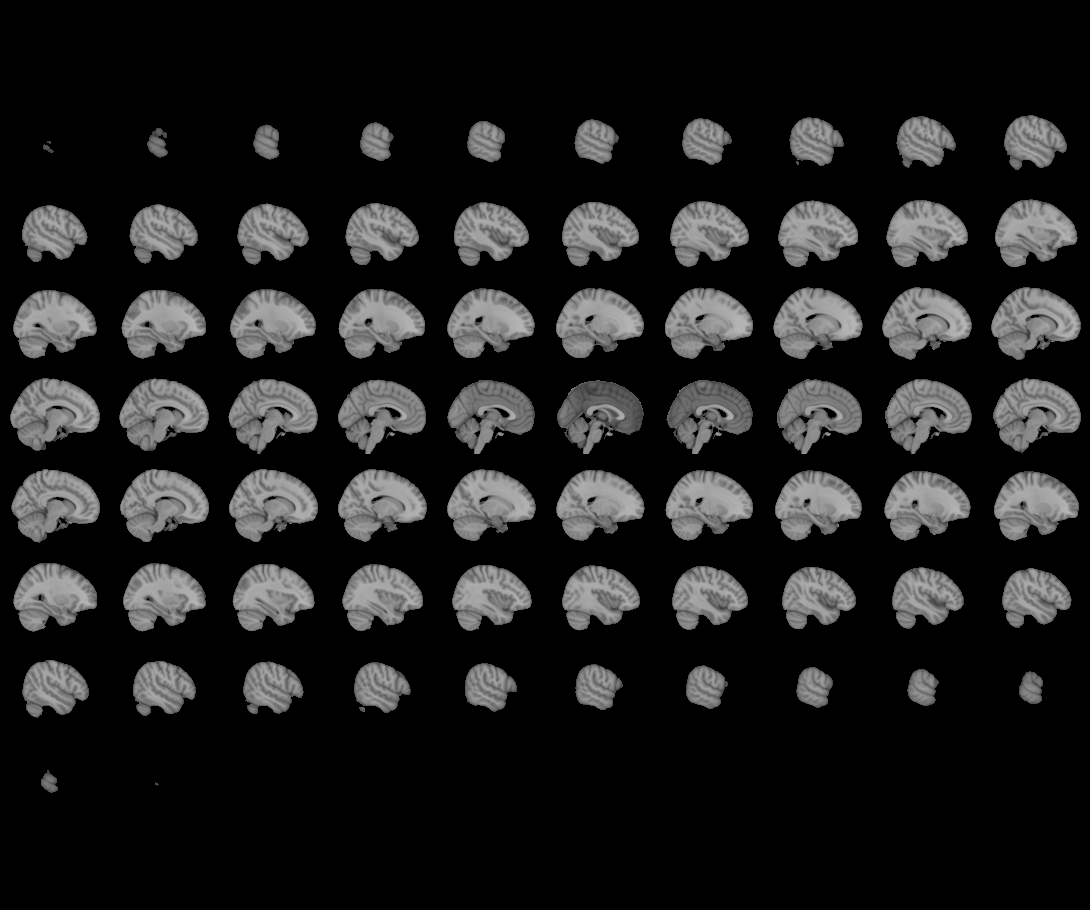
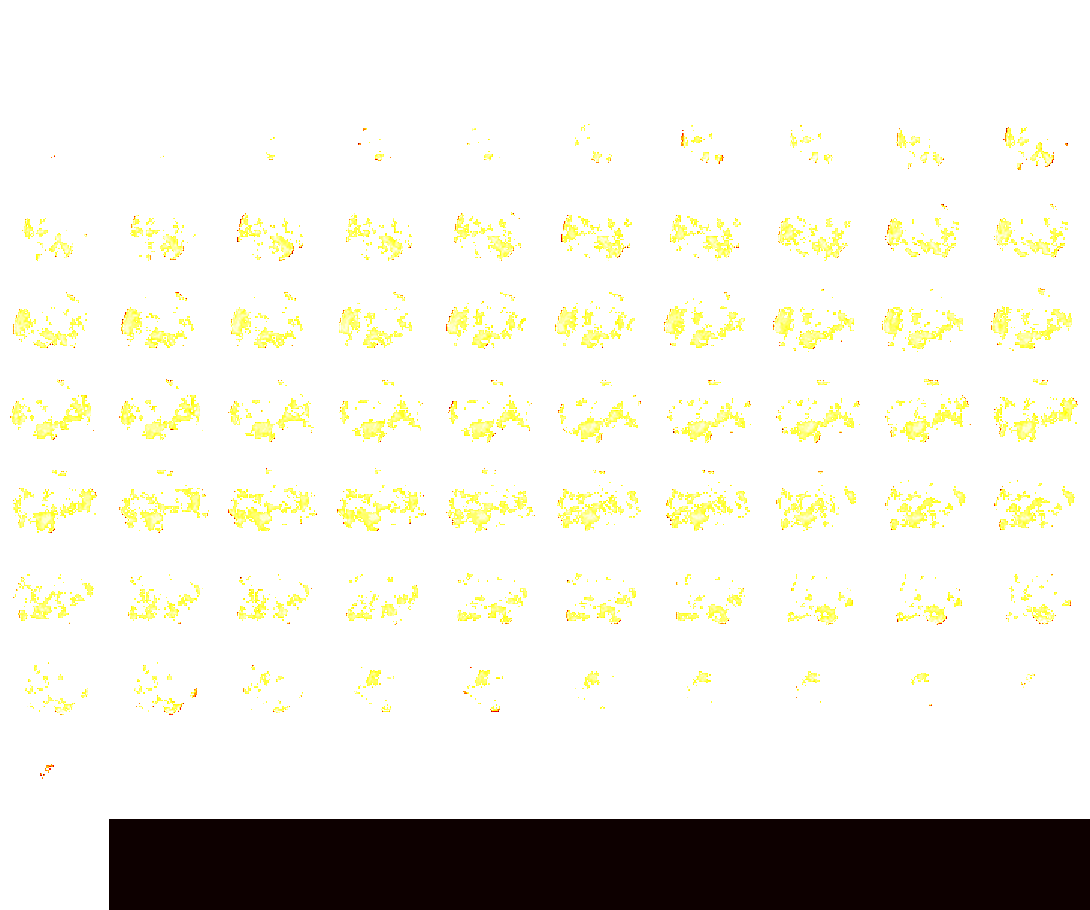

In [31]:
plotting.view_img(searchlight_img, threshold=0.75)